# InstaSpot

Our main goal is to be able to recommend new travel destinations to users based on their interest in travel posts on Instagram. To achieve this, we will explore different ways to build recommender systems. We will compare results between a content-based and a matrix factorization based collaborative filtering approach.

## Table of Content

1. Importing modules
  * Initialize spark session
  * Define metadata
2. Data processing
  * Retrieve travel influencers  
  * Extract travel post metadata
  * Extract relevant fields
  * Create dataframe
3. Data Analysis
  * Location
  * Instagram users
  * Accessibility caption
  * Caption & Hashtags
4. Content-Based Recommendation
5. Latent Factor Models
  * Model 1
  * Model 2
  * Model 3
  * Hyperparameter tuning
6. Model Comparison

## 1. Importing modules

First, let's import some libraries that we're going to use in the notebook.

In [1]:
import csv
import difflib
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from zipfile import ZipFile
from pyspark.rdd import RDD
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.functions import sum
from pyspark.sql.functions import lit
from pyspark.sql.functions import udf
from pyspark.sql.functions import count
from pyspark.sql.functions import explode
from pyspark.sql.types import IntegerType
from pyspark.sql.types import DoubleType
from pyspark.ml.recommendation import ALS
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

Let's also initialize our spark session

In [2]:
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Python Spark SQL basic example") \
        .config("spark.ui.showConsoleProgress", 'false') \
        .getOrCreate()
    return spark

In [3]:
spark = init_spark()

22/04/01 21:43:32 WARN Utils: Your hostname, cnmk.local resolves to a loopback address: 127.0.0.1; using 192.168.0.54 instead (on interface en0)
22/04/01 21:43:32 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/01 21:43:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Let's define some metadata

In [4]:
# To modify accordingly
DATASET_PATH = 'data/post-metadata/*.info'
INFLUENCER_TEXT_PATH = 'data/influencers.txt'
LOCATIONS = {}
USERS = {}
SEED = 123

## 2. Data processing

Our [dataset](https://sites.google.com/site/sbkimcv/dataset#h.4eo4r5p70z10) comes from Proceedings of The Web Conference (WWW 20), ACM, 2020, provided by Seungbae Kim.

This dataset classified influencers into nine categories namely *beauty, family, fashion, fitness, food, interior, pet, travel, and others*. It contains 300 posts per influencer, so there are over 10 million Instagram posts where each influencer is categorized based on their post metadata. Each post metadata file is in JSON format.

### Retrieve travel influencers


Since we're only interested in travel influencers, we will retrieve all usernames from the travel category using <code>influencers.txt</code> which contains a list of influencers with their Instagram username, category, the number of followers, followees, and posts.

In [5]:
lines = spark.sparkContext.textFile(INFLUENCER_TEXT_PATH)

# get category and username index
headers = lines.take(2)
header = headers[0]
category_index = header.split("\t").index("Category")
username_index = header.split("\t").index("Username")
post_index = header.split("\t").index("#Posts")

# filter travel influencers
lines = lines.filter(lambda line: line not in headers)
lines = lines.map(lambda line: line.split("\t"))
travel_influencers = lines.filter(lambda line: line[category_index] == 'travel')
# get all travel influencers IG username
travel_usernames = travel_influencers.map(lambda line: line[username_index])

print('Total travel users:',travel_usernames.count())

Total travel users: 4210


As we can see above, there were 4210 instagram users categorized as travel influencers. 

### Extract travel post metadata 
Now let's go ahead and extract the post metadata of those users only. Each post metadata filename starts with a username followed by a post ID. 

In [6]:
# TODO: Add code to extract travel influencers info files


### Extract relevant fields
Since there are more information than we need, we will extract relevant fields from the JSON files.

The following fields are the ones we found the most relevant to our project:

| Fields               | Description                                      |
| :------------------- | :------------------------------------------------|
| post_id              | ID of the instagram post                         |
| owner_id             | owner id of instagram post                       |
| owner_username       | owner username of instagram post                 |
|accessibility_caption | describes what the post is about                 |
|likes_count           | number of likes the post received                |
|comments_count        | number of comments the post received             |
|commenters_id         | ID list of users who commented on the post       |
|commenters_username   | username list of users who commented on the post |
|tagged_users_id       | ID list of tagged users on the post              |
|tagged_users_username | username list of tagged users on the post        |
|caption               | caption of the post                              |
|hashtags              | hashtags from caption of the post                |
|location_id           | location id of the post                          |
|location_name         | location name of the post                        |

### Helper functions

Below are helper functions that will extract the required fields.

In [7]:
# helper function to extract counts
def extract_counts(row, field):
    if field not in row:
        return 0
    if row[field] is None:
        return 0
    if 'count' not in row[field] or row[field]['count'] is None:
        return 0
    return int(row[field]['count'])

# helper function to traverse user network
def extract_nodes_from_edges(row, field, secondary_fields):
    result = []
    if field not in row or row[field] is None \
    or 'edges' not in row[field] or row[field]['edges'] is None:
        return []

    for edge in row[field]['edges']:
        if 'node' in edge and edge['node']:
            no_error = True
            temp = edge['node']
            for f in secondary_fields:
                if f in temp and temp[f]:
                    temp = temp[f]
                else:
                    no_error = False
                    
            if no_error:
                result.append(temp)
 
    return result

# helper function to extract tagged users from caption
def extract_tagged_users(caption):
    tagged = []
    if caption is None or len(caption) == 0:
        return tagged
    else: 
        for word in caption[0].split():
            if word[0] == '@':
                tagged.append(word[1:])
        return tagged
    
# likes_count
def likes(row):
    return extract_counts(row, 'edge_media_preview_like')

# comments_count
def comments_count(row):
    return extract_counts(row, 'edge_media_to_parent_comment')

# tagged_users_id
def extract_tagged_users_id(row):
    tagged_ls = extract_nodes_from_edges(row, 'edge_media_to_tagged_user', ['user', 'id'])
    return list(map(int, tagged_ls))

# tagged_users_username
def extract_tagged_users_username(row):
    return extract_nodes_from_edges(row, 'edge_media_to_tagged_user', ['user', 'username'])

# commenters_id
def extract_commenters_id(row):
    comm_ls = extract_nodes_from_edges(row, 'edge_media_to_parent_comment', ['owner', 'id'])
    return list(map(int, comm_ls))

# commenters_username
def extract_commenters_username(row):
    return extract_nodes_from_edges(row, 'edge_media_to_parent_comment', ['owner', 'username'])

# hashtags
def extract_hashtags(caption):
    hashtags = []
    if caption is None or len(caption) == 0:
        return hashtags
    else: 
        for word in caption[0].split():
            if word[0] == '#':
                hashtags.append(word[1:])
        return hashtags

# caption
def extract_text_from_caption(row):
    result = []
    if 'edge_media_to_caption' not in row or row['edge_media_to_caption'] is None \
    or 'edges' not in row['edge_media_to_caption'] or row['edge_media_to_caption']['edges'] is None:
        return []
    
    for edge in row['edge_media_to_caption']['edges']:
        if 'node' in edge and edge['node'] and 'text' in edge['node']:
            result.append(edge['node']['text'])
    return result

# location id, name
def extract_location(row):
    result = {
        'location_name': '',
        'location_id': ''
    }
    if 'location' in row and row['location']:
        if 'name' in row['location'] and 'id' in row['location']:
            result['location_name'] = row['location']['name']
            result['location_id']   = int(row['location']['id'])
        
    return result

# owner_id
def extract_post_owner_id(row):
    if 'owner' not in row or row['owner'] is None:
        return ''

    if 'id' not in row['owner'] or row['owner']['id'] is None:
        return ''

    return int(row['owner']['id'])

# owner_username
def extract_post_owner_username(row):
    if 'owner' not in row or row['owner'] is None:
        return ''
    
    if 'username' not in row['owner'] or row['owner']['username'] is None:
        return ''

    return row['owner']['username']

# post_id
def extract_post_id(row):
    if 'id' not in row or row['id'] is None:
        return ''
    
    return int(row['id'])

# accessibility_caption
def extract_accessibility_caption(row):
    if 'accessibility_caption' not in row or row['accessibility_caption'] is None:
        return ''
    
    return row['accessibility_caption']
    
# returns an RDD where each row is a json file 
def create_post_as_json(row):
    post_id = extract_post_id(row)
    location = extract_location(row)
    owner_id = extract_post_owner_id(row)
    owner_username = extract_post_owner_username(row)
    caption = extract_text_from_caption(row)
    hashtags = extract_hashtags(caption)
    likes_count = likes(row)
    tagged_users_id = extract_tagged_users_id(row)
    tagged_users_username = extract_tagged_users_username(row) # TODO: ADD @ FROM CAPTIONS
    commenters_id = extract_commenters_id(row)
    commenters_username = extract_commenters_username(row)
    comment_count = comments_count(row)
    accessibility_caption = extract_accessibility_caption(row)
    
    return {
        'post_id': post_id,
        'owner_id': owner_id,
        'owner_username': owner_username,
        'location_id' : location['location_id'],
        'location_name' : location['location_name'],
        'likes_count': likes_count,
        'comments_count': comment_count,
        'commenters_id': commenters_id,
        'commenters_username': commenters_username,
        'tagged_users_id': tagged_users_id,
        'tagged_users_username': tagged_users_username,
        'caption': caption,
        'hashtags': hashtags,
        'accessibility_caption': accessibility_caption     
    }

# converts a json file into tuples
def convert_json_to_tuple(row):
    post_id = row['post_id']
    location_name = row['location_name']
    location_id = row['location_id']
    likes_count = row['likes_count']
    owner_id = row['owner_id']
    owner_username = row['owner_username']
    caption = row['caption']
    hashtags = row['hashtags']
    tagged_users_id = row['tagged_users_id']
    tagged_users_username = row['tagged_users_username']
    commenters_id = row['commenters_id']
    commenters_username = row['commenters_username']
    accessibility_caption = row['accessibility_caption']
    comment_count = row['comments_count']
    return (post_id, owner_id, owner_username, location_id, location_name,
            likes_count, comment_count, commenters_id, commenters_username,
            tagged_users_id, tagged_users_username, caption, hashtags,
            accessibility_caption)

# when exporting the data to CSV, it doesn't allow arrays, so the they need to be converted to strings
def flatten_json_lists(row):
    row['caption'] = '. '.join(row['caption'])
    row['hashtags'] = ', '.join(row['hashtags'])
#     row['tagged_users_id'] =  ', '.join(row['tagged_users_id'])
    row['tagged_users_username'] =  ', '.join(row['tagged_users_username'])
#     row['commenters_id'] = ', '.join(row['commenters_id'])
    row['commenters_username'] =  ', '.join(row['commenters_username'])
    return row

# function that replaces "\r" with "\n"
def remove_carry_returns(row):
    row['caption'] = row['caption'].replace('\r', '').replace('\n', ' ')
    return row

Now that we are all set, we will read all JSON files into an RDD,

In [8]:
df = spark.read.json(DATASET_PATH)
rdd =  df.rdd

22/04/01 21:44:26 WARN SharedInMemoryCache: Evicting cached table partition metadata from memory due to size constraints (spark.sql.hive.filesourcePartitionFileCacheSize = 262144000 bytes). This may impact query planning performance.


We will then map our helper functions to extract the neccessary fields

In [9]:
#transform data to the needed format
rdd = rdd.map(lambda r: create_post_as_json(r)).\
    map(lambda r: flatten_json_lists(r)).\
    map(lambda r: remove_carry_returns(r)).\
    map(lambda r: convert_json_to_tuple(r))

And finally convert our RDD into a dataframe with the following schema to better explore our data

In [10]:
schema = ['post_id', 'owner_id', 'owner_username','location_id', 'location_name',
          'likes_count', 'comments_count', 'commenters_id', 'commenters_username',
          'tagged_users_id', 'tagged_users_username', 'caption', 'hashtags',
          'accessibility_caption']

df = rdd.toDF(schema)

In [11]:
df.count()

68353

As we can see above, we collected 68,353 post metadata.

Let's have a look at the first 20 rows.

In [12]:
df.limit(20).toPandas().head(20)

,post_id,owner_id,owner_username,location_id,location_name,likes_count,comments_count,commenters_id,commenters_username,tagged_users_id,tagged_users_username,caption,hashtags,accessibility_caption
0,1875572106509410527,398526345,thetravellingbeautyqueen,5.670778e+08,Mexico,11813,151,"[1148667561, 177036590, 191099913, 308451883, ...","normandothemagician, waelalteen, remybaghdady,...","[28760386, 194294592, 215212085, 306780945, 36...","mexicotravel, peperlupe, camillawithlove, yuca...",My newest - 21 st magazine cover😊👸🏼👑📸❤ Mid Tim...,"thetravellingbeautyqueen, lenkajosefiova, cove...",
1,1829719472242373040,3597572,pinnywooh,2.563929e+08,Valley of Fire State Park,7163,219,"[318445882, 1691724710, 3032894450, 254938180,...","mrs_vernova, giingerann, misssebyaha, puercoes...",[],,"Обещала вам пост, как выглядит типичный рабочи...",,
2,1881175916568618668,756368100,putopis,NaN,,936,41,"[176130500, 768082182, 6113944286, 5325916, 28...","naturetalker, zeljka_dja, travelbookcroatia, a...","[21943587, 23947096, 181415118, 215124008, 276...","huffpost, natgeotravel, foodandwine, jetsettim...",Rovinj is a town full of beautiful colors and ...,"Podravka, vegetamaestro, rovinj, istria, cooli...",
3,1802821674903711318,17205419,mahfamily5,2.022789e+14,Edmonds Marina Beach Park,120,29,"[17205419, 17205419, 7008936574, 7144133477, 7...","mahfamily5, mahfamily5, glampfam, mcculloughsw...","[716750476, 1024912394, 1553633873, 3288300648...","momswithcameras, king5evening, edmondsdowntown...",Mia had a great morning despite the little sle...,,
4,1938656069423140660,2088079721,frabjous_existence,1.300522e+15,The Rooftop at Pier 17,288,46,"[6774931332, 2088079721, 5533385199, 690045046...","giu_lucchi, frabjous_existence, lewisnation.lo...","[18078794, 19009288, 21723588, 27410259, 20814...","nycgo, nbcnewyork, nymag, uonewyork, streeteas...","ᴛᴀsᴛʏ ᴛʜᴜʀsᴅᴀʏ, ᴀɴᴅ ᴛᴏᴅᴀʏ ᴡᴇ ᴠᴇɴᴛᴜʀᴇ ᴅᴏᴡɴ ᴛᴏ ᴘ...",skatetheskyline,
5,1910816411687530750,2149187649,vivircorriendo,2.150268e+08,"Donostia-San Sebastián, Spain",1667,36,"[264336303, 250260, 7915197480, 1024511319, 10...","soyloquevivo, vaboom, carloantoniobaroni, davi...","[24570782, 29873342, 32188770, 45949544, 20015...","raulgomez82, odlo, igor_quijano, mariamainez, ...",EMBAJADORA 50/50/25 . Gracias a la Organizació...,"bss505025, VivircorRiendo, QueAReirNoTeGaneNad...",
6,2022997046060861046,5851437,griffinthall,2.346263e+08,"Coachella, California",1064,31,"[21787221, 9053350, 38223425, 22831662, 207836...","dyluxe, chasefisher, aaron.griver, markweeeene...","[4724305, 5851437, 5878398, 7641344, 8138633, ...","andiefitzgerald, griffinthall, sarah_cothren, ...",Such an incredible #Coachella weekend with the...,"Coachella, livefree, puravidabracelets, pvtake...",
7,1883554250934263592,513006206,zitamaleki,1.481296e+15,Bittersweet,1429,33,"[7592647359, 651681146, 2124063267, 3949779833...","_baran.mystyle_, almaa_food, fafa.trv, h._zahr...","[6942978, 20158039, 20528476, 145363808, 17689...","express, fendi, pierrecardintr, swarovski, cha...",حتمن یادتون میاد که یه موقعی این بحث خیلی داغ ...,,
8,1997024571324339641,1539201055,high_vis,3.003208e+06,American Airlines Center,373,0,[],,"[6114566, 13657382, 14536518, 179450081, 21943...","dallasmavs, valerie_ramirez, cyntgm, sportsill...",Killer @dallasmavs halftime show by @inthelab2...,"Truemaverick, dallasmavericks, dallasmavsshop",
9,2013304121478023187,199833517,viaja_inspirado,2.148811e+08,"Valparaíso, Chile",1162,0,[],,"[199833517, 260190008, 319958459, 483633802, 1...","viaja_inspirado, sientevalpo, chiletravel, fco...",Valparaiso de mi amor ❤️🎶 Que lindo es Valpara...,,


## 3. Data Analysis

So far we have been discovering and structuring our data. Our next step will be to perform a descriptive data analysis to have a better summary our features.

Since performing action functions on this huge amount of data can be costly, we will only focus on the most important features. 

### Location

Let's have a look at the number of unique values in <code>location_id</code> and <code>location_name</code>. 

In [13]:
print("location_id: ", df.select("location_id").distinct().count())

location_id:  24853


In [14]:
print("location_name: ", df.select("location_name").distinct().count())

location_name:  24068


Since the number unique values of <code>location_id</code> and <code>location_name</code> differ, we can deduce that there are some post metadata that have missing location info. 

Let's count how many times <code>location_id</code> and <code>location_name</code> are both missing in a post metadata.

In [15]:
df.filter((col("location_id").isNull()) & (col("location_name") == '')).count()

19760

Let's also count the number of times a post metadata has <code>location_name</code> missing but has a <code>location_id</code> and vice versa.

In [16]:
df.filter((col("location_id").isNotNull()) & (col("location_name") == '')).count()

0

In [17]:
df.filter((col("location_id").isNull()) & (col("location_name") != '')).count()

0

Based on the missing counts above, we noticed that there are 19,760 post metadata with no information about its location, therefore we will drop these rows.

In [18]:
df = df[(df.location_id.isNotNull()) & (df.location_name != '')]

In [19]:
assert df.count() == (68353-19760)
print("19760 rows dropped successfully!")

19760 rows dropped successfully!


We will also create a dictionary of location.

In [20]:
location_id = df.select("location_id").collect()
location_name = df.select("location_name").collect()

In [21]:
for loc_id, loc_name in zip(location_id, location_name):
    if loc_id[0] in LOCATIONS:
        pass
    else:
        LOCATIONS[loc_id[0]] = loc_name[0]

In [22]:
len(LOCATIONS)

24852

### Instagram Users

In [23]:
owner_id = df.select("owner_id").collect()
owner_username = df.select("owner_username").collect()
commenters_id = df.select("commenters_id").collect()
commenters_username = df.select("commenters_username").collect()
tagged_users_id = df.select("tagged_users_id").collect()
tagged_users_username = df.select("tagged_users_username").collect()

In [24]:
for owner_id, owner_name in zip(owner_id, owner_username):
    if owner_id[0] in USERS:
        pass
    else:
        USERS[owner_id[0]] = owner_name[0]

In [25]:
for comm_id, comm_name in zip(commenters_id, commenters_username):
    c_id = comm_id[0]
    c_name = comm_name[0]
    for cId, cName in zip(c_id, c_name):
        if cId in USERS:
            pass
        else:
            USERS[cId] = cName

In [26]:
for tag_id, tag_name in zip(tagged_users_id, tagged_users_username):
    t_id = tag_id[0]
    t_name = tag_name[0]
    for tId, tName in zip(t_id, t_name):
        if tId in USERS:
            pass
        else:
            USERS[tId] = tName

In [27]:
len(USERS)

349257

### Accessibility Caption

We will now take a look at <code>accessibility_caption</code>

In [28]:
df.filter((col("accessibility_caption") != '') & 
          (col("accessibility_caption") != 'No photo description available.')).limit(5).toPandas().head(5)

,post_id,owner_id,owner_username,location_id,location_name,likes_count,comments_count,commenters_id,commenters_username,tagged_users_id,tagged_users_username,caption,hashtags,accessibility_caption
0,1764716511598871662,3442535492,couple_around_the_world,213045606,St. Paul's Cathedral,615,53,"[5613403460, 1520835524, 5064849724, 558125139...","passiontravelers, brisbanefamilyexplorers, yuk...","[18653141, 218204713, 221827472, 303273692, 32...","londonarchitecture, visitengland, architecture...",Sometimes you just have to stop and admire the...,,"Image may contain: one or more people, people ..."
1,1928919091570114766,237255794,niko0o0o,272675853354272,Iranmehr Hospital بیمارستان ایرانمهر,8770,353,"[1557411337, 189702389, 1450110238, 43489340, ...","mahsa_bano_v, kolinoosh, pegah_vrz, omiddg55, ...",[],,• نمی‌دونم شما تجربه تلخ بودن توی یک تصادف رو ...,,Image may contain: indoor
2,1783962564531625928,28431316,irina_ls,3001453,Millennium Park,2090,44,"[28431316, 11712605, 465298586, 1519223122, 15...","irina_ls, tycolllins, el.voroshilova, gubanova...","[222301553, 225180463, 1101825364, 1642751093,...","choosechicago, chicagobucketlist, insta_chicag...",🎶rita ora – girls ⠀ who am i if not a princes...,"usa_withirinls, иринблогпроньюйорк","Image may contain: 2 people, outdoor"
3,1773896275306061138,21474914,alleksana,215231527,"Hampstead, United Kingdom",2202,64,"[27735783, 52456658, 4111776536, 179448265, 23...","verchik_magjanova, victo_somewhere, suitcaseof...",[],,Когда ты в субботу неожиданно попал в клуб и в...,,"Image may contain: plant, tree, flower and out..."
4,1825519529327637742,1300539481,dan_stagen,218214254,"Oía, Kikladhes, Greece",1241,42,"[5913421695, 269042164, 350209917, 288085091, ...","takemyhearteverywhere, leksa_diary, kasia_life...","[233942711, 342711792, 449270888, 515489346, 9...","visitgreecegr, paul_hewitt, wu_greece, visitgr...",ВСЯ ПРАВДА О САНТОРИНИ🇬🇷 «Часть ||» ⠀⠀ Как вы ...,stagen_santorini,"Image may contain: sky, ocean, outdoor and water"


In the previous section the first 20 rows of the column <code>accessibility_caption</code> were missing values, let's see how many in total are missing

In [29]:
df.filter((col("accessibility_caption") == '')).count()

3855

In [30]:
df.filter((col("accessibility_caption") == 'No photo description available.')).count()

12117

In [31]:
df.filter((col("accessibility_caption") != '') &
          (col("accessibility_caption") != 'No photo description available.')).count()

32621

<code>TODO:</code> conclude why accessibility_caption still useful for us even if many are missing

### Caption & Hashtags

In [32]:
# en = 0
# other = 0
# for i in df.select("caption").collect():
#     lang = TextBlob(i[0]) 
#     print(lang.detect_language())
#     print(type(lang.detect_language()))
# #     if lang.detect_language() == "en":
# #         en += 1
# #     else:
# #         other += 1
        
# print("English: ", en)
# print("Other: ", other)

## 4. Content Based Recommendation

In [33]:
pandas_df = df.toPandas()

Combine features for similarity extraction

In [34]:
combined_features = pandas_df["location_name"] + " " + pandas_df["hashtags"] + " " + \
                    pandas_df["caption"] + " " + pandas_df["accessibility_caption"]

In [35]:
print(combined_features)

0        Mexico thetravellingbeautyqueen, lenkajosefiov...
1        Valley of Fire State Park  Обещала вам пост, к...
2        Edmonds Marina Beach Park  Mia had a great mor...
3        The Rooftop at Pier 17 skatetheskyline ᴛᴀsᴛʏ ᴛ...
4        Donostia-San Sebastián, Spain bss505025, Vivir...
                               ...                        
48588    Concert @ Sea  Golden Earring. Hard. Goed! No ...
48589    Gateway Arch Missouri St. Louis #Missouri No p...
48590    St.Tropez Yacht Port  Port St. Tropez ⚓️ No ph...
48591    Toulouse, France  s u n d a y No photo descrip...
48592    Golden Bee sol, sunny, London, moments #sol #s...
Length: 48593, dtype: object


Use TF-IDF Vectorizer to convert the text data to feature vectors

In [36]:
vectorizer = TfidfVectorizer()

In [37]:
feature_vectors = vectorizer.fit_transform(combined_features)

In [38]:
print(feature_vectors)

  (0, 159293)	0.07929269527660017
  (0, 123498)	0.07929269527660017
  (0, 124669)	0.016135058550480853
  (0, 83600)	0.07434036400056193
  (0, 150708)	0.07639576718896923
  (0, 83599)	0.06400255648427022
  (0, 82788)	0.07274606942761583
  (0, 48556)	0.0653897436931544
  (0, 93503)	0.03723822559612455
  (0, 55010)	0.03703281955455497
  (0, 105896)	0.04361327226849222
  (0, 14960)	0.038770767807356235
  (0, 70572)	0.03886982941193402
  (0, 33113)	0.05806996383772498
  (0, 181259)	0.0333140346752936
  (0, 126171)	0.030264060670833454
  (0, 98809)	0.04207245990615057
  (0, 72826)	0.03165017975237631
  (0, 112833)	0.02467030213522473
  (0, 55540)	0.05106222937327943
  (0, 41124)	0.04339855716531543
  (0, 84810)	0.15858539055320034
  (0, 92372)	0.14868072800112386
  (0, 113233)	0.03263150925022463
  (0, 151287)	0.037925144999346475
  :	:
  (48589, 153475)	0.24683944233887492
  (48590, 169120)	0.6594016185272257
  (48590, 127880)	0.5093503775951874
  (48590, 184383)	0.28789964725605116
  (4859

Find cosine similarity of feature vectors

In [39]:
similarity = cosine_similarity(feature_vectors)

In [40]:
print(similarity.shape)

(48593, 48593)


Take User Input for a location. We have chosen 'San Diego' as an example

In [41]:
user_input = input('Please input a location: ')

Please input a location: San Diego


Get all the locations

In [42]:
locations_list = pandas_df["location_name"].tolist()

Find the closest match to our user inputted location

In [43]:
find_closest_match = difflib.get_close_matches(user_input, locations_list)

In [44]:
close_match = find_closest_match[0]

In [45]:
print(close_match)

San Diego Zoo


Find the index of the closest match

In [46]:
index_close_match = pandas_df.index[pandas_df["location_name"] == close_match][0]

In [47]:
print(index_close_match)

22198


Get the similarity scores of all the locations to our closest match

In [48]:
similarity_score = list(enumerate(similarity[index_close_match]))

In [49]:
print(similarity_score)

[(0, 0.03121050919876367), (1, 0.0), (2, 0.025054280224996683), (3, 0.04574268354183754), (4, 0.011913001342339214), (5, 0.045978405202697276), (6, 0.0), (7, 0.00646118430296506), (8, 0.0019493002992473272), (9, 0.0372142392933819), (10, 0.04549630164264748), (11, 0.0), (12, 0.03738292720443396), (13, 0.00817061661434513), (14, 0.0397021724228215), (15, 0.0), (16, 0.07194140074136268), (17, 0.01567586733750639), (18, 0.0760739470966602), (19, 0.009979561803181214), (20, 0.008528818686479644), (21, 0.03671322333569412), (22, 0.019732258366738614), (23, 0.0480924393240748), (24, 0.034321723019259176), (25, 0.0), (26, 0.008415853368662319), (27, 0.047346695872922576), (28, 0.08013283526750681), (29, 0.0), (30, 0.0), (31, 0.01679846454054678), (32, 0.0), (33, 0.0), (34, 0.0634445886547311), (35, 0.018391507112308768), (36, 0.01591387801118378), (37, 0.05931921412382346), (38, 0.0015038789292374352), (39, 0.0), (40, 0.010933396573844602), (41, 0.043217406408286765), (42, 0.0), (43, 0.0), (4

In [50]:
len(similarity_score)

48593

Graph showing the locations and their similarity scores

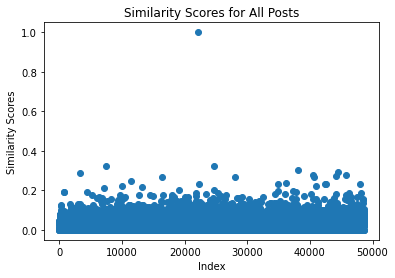

In [51]:
plt.scatter(*zip(*similarity_score))
plt.title("Similarity Scores for All Posts")
plt.xlabel("Index")
plt.ylabel("Similarity Scores")
plt.show()

Sort our similarity_score array from highest to lowest similarity score

In [52]:
sorted_locations = sorted(similarity_score, key = lambda x:x[1], reverse=True)

In [53]:
print(sorted_locations)

[(22198, 1.0), (7479, 0.32252091782776493), (24640, 0.32100653884931374), (38067, 0.30502062024682147), (44524, 0.29321165691260026), (3332, 0.28812232407867056), (40447, 0.2774640123295342), (45715, 0.27739264139314207), (44080, 0.2736359804397266), (40613, 0.26979980221539585), (16301, 0.26862179590915136), (28049, 0.2676675117390702), (11479, 0.24700456758003503), (36217, 0.23908289283652417), (42451, 0.23327293922832829), (48000, 0.23253247403771513), (42513, 0.2325191075304729), (22350, 0.23226532577606607), (34947, 0.2312711406979761), (40894, 0.22449482517518948), (9949, 0.22325834786039575), (13178, 0.21605237038744776), (7067, 0.2143388465706056), (19062, 0.2039966214821259), (24628, 0.20208743689851824), (37282, 0.19902947310964902), (34840, 0.1967710011671834), (37711, 0.19311474572854295), (714, 0.19236915889531447), (4433, 0.1917976421226366), (686, 0.18938368011545326), (25354, 0.1874736315373328), (48171, 0.185842575419542), (46293, 0.18512402322334934), (21863, 0.184554

Show the top 5 recommended locations

In [54]:
print("Top 5: Locations suggested for you: \n")
x = []
y = []
i = 1
for location in sorted_locations:
    index = location[0]
    location_name = pandas_df[pandas_df.index == index]["location_name"].values
    if (i <= 5):
        x.append(location_name[0])
        y.append(location[1])
        print(i,'.',location_name[0])
        i+=1

Top 5: Locations suggested for you: 

1 . San Diego Zoo
2 . Sunset Cliffs, San Diego
3 . Blue Mountains National Park
4 . Normal Heights, San Diego
5 . Pacific Beach, San Diego


Graph showing the top 5 suggested location and their similarity scores

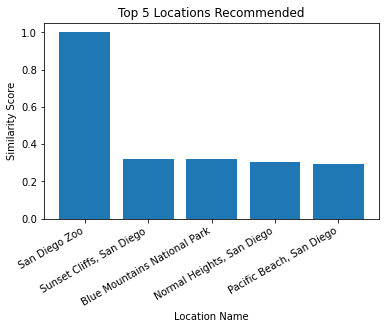

In [55]:
fig, ax = plt.subplots()
ax.bar(x, y, linestyle='-')
ax.set_ylabel("Similarity Score")
ax.set_xlabel("Location Name")
ax.set_title("Top 5 Locations Recommended")
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
fig.autofmt_xdate()

## 5. Latent Factor Models

**Note:** The DataFrame-based API for ALS currently only supports integers for user and item ids. Other numeric types are supported for the user and item id columns, but the ids must be within the integer value range.

In [56]:
# TODO : Helper functions to train and evaluate
def flatten_(v):
    try:
        return float(v[0])
    except ValueError:
        return None

flatten = udf(flatten_, DoubleType())

### Model 1

In [57]:
LF_df = df.select("owner_id", "location_id")
LF_df = LF_df.withColumn("owner_id", col("owner_id").cast(IntegerType())).\
    withColumn("location_id", col("location_id").cast(IntegerType())).\
    withColumnRenamed("owner_id", "user_id")

In [58]:
LF1 = LF_df.groupby("user_id", "location_id").count()

In [59]:
(training, test) = LF1.randomSplit([0.8, 0.2], seed=SEED)

als = ALS(maxIter=5, regParam=0.01, rank=70, coldStartStrategy="drop",
          userCol="user_id", itemCol="location_id", ratingCol="count").setSeed(SEED)
model = als.fit(training)

predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="count",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print(rmse)

22/04/01 22:02:23 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/04/01 22:02:23 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
22/04/01 22:02:23 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


1.6900541784176062


### Model 2

In [60]:
tagged_df = df.select(explode(df.tagged_users_id).alias("user_id"),"location_id")
tagged_df = tagged_df.withColumn("user_id", col("user_id").cast(IntegerType())).\
    withColumn("location_id", col("location_id").cast(IntegerType()))

In [61]:
LF2 = LF_df.union(tagged_df)

In [62]:
assert LF2.count() == (tagged_df.count() + LF_df.count())
print("Dataframes merged successfully!")

Dataframes merged successfully!


In [63]:
LF2 = LF2.groupby("user_id", "location_id").count()

In [64]:
(training, test) = LF2.randomSplit([0.8, 0.2], seed=SEED)

als = ALS(maxIter=5, regParam=0.01, rank=70, coldStartStrategy="drop",
          userCol="user_id", itemCol="location_id", ratingCol="count").setSeed(SEED)
model = als.fit(training)

predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="count",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print(rmse)

1.2695972471094552


### Model 3

In [65]:
LF_df = df.select("owner_id", "location_id", "likes_count")
LF_df = LF_df.withColumn("owner_id", col("owner_id").cast(IntegerType())).\
    withColumn("location_id", col("location_id").cast(IntegerType())).\
    withColumnRenamed("owner_id", "user_id")

In [66]:
tagged_df = df.select(explode(df.tagged_users_id).alias("user_id"),"location_id", "likes_count")
tagged_df = tagged_df.withColumn("user_id", col("user_id").cast(IntegerType())).\
    withColumn("location_id", col("location_id").cast(IntegerType()))

In [67]:
LF3 = LF_df.union(tagged_df)

In [68]:
assert LF3.count() == (tagged_df.count() + LF_df.count())
print("Dataframes merged successfully!")

Dataframes merged successfully!


In [69]:
LF3 = LF3.groupby("user_id", "location_id").agg(count('*').alias("count"),\
                                                sum(LF3.likes_count).\
                                                alias("sum_likes")) 

In [70]:
LF3 = LF3.withColumn("bias_count", col("count") + col("sum_likes"))

Convert df column to vector to be able to fit and transform with MinMaxScaler

In [71]:
assembler = VectorAssembler(inputCols=["bias_count"], outputCol="bias_count_vec")

LF3 = assembler.transform(LF3)

Rescaling rating to range [0,5]

In [72]:
(training, test) = LF3.randomSplit([0.8, 0.2], seed=SEED)

scaler = MinMaxScaler(min=0.0, max=5.0, inputCol="bias_count_vec", outputCol="norm_count")

model = scaler.fit(training)

In [73]:
training = model.transform(training)
test = model.transform(test)

Flatten Columns

In [76]:
training = training.withColumn("norm_count", flatten("norm_count"))
test = test.withColumn("norm_count", flatten("norm_count"))

In [78]:
als = ALS(maxIter=5, regParam=0.01, rank=70, coldStartStrategy="drop",
          userCol="user_id", itemCol="location_id", ratingCol="norm_count").setSeed(SEED)
model = als.fit(training)

predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="norm_count",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print(rmse)

0.051333449108611366


### Hyperparameter Tuning

60% Training, 20% Validation, 20% Testing

In [ ]:
# TODO: Hyperparameter tuning
regParam = [0.01, 0.1, 1.0, 10.0, 100.0]
iterations = [5, 10, 15, 20, 25]
rank = [5, 10, 15, 20, 25]